In [1]:
using CairoMakie
using ColorSchemes
using DataFrames
using LinearAlgebra
include("lib.jl")


# these are relative to 1 CSS px
inch = 96
pt = 4/3
cm = inch / 2.54
default_width = 9 * cm  # Column width

340.1574803149606

## Train trajectories

In [2]:
λ_range = [
    0.0,
    0.25,
    0.5,
    0.75,
    1.0,
]
cmap = resample(ColorSchemes.cool, length(λ_range))

In [3]:
data = Dict()
# files = ["train$(λ)/trajectory.json" for λ in λ_range]
files = [
    "train0.0/trajectory.json",
    "train0.25/trajectory.json",
    "train0.5/trajectory.json",
    "train0.75/trajectory.json",
    "train1.0/trajectory.json",
]
for file in files
    traj = JSON3.read(file)
    df = DataFrame()
    for state in traj
        if haskey(state, "loss")
            row = (;
                theta=state["theta"],
                loss=state["loss"],
                grad=state["grad"],
                cases=state["cases"],
            )
            push!(df, deepcopy(row))
        end
    end
    data[file] = df
end
data

Dict{Any, Any} with 5 entries:
  "train0.75/trajectory.json" => 128×4 DataFrame…
  "train0.5/trajectory.json"  => 113×4 DataFrame…
  "train0.25/trajectory.json" => 122×4 DataFrame…
  "train0.0/trajectory.json"  => 129×4 DataFrame…
  "train1.0/trajectory.json"  => 126×4 DataFrame…

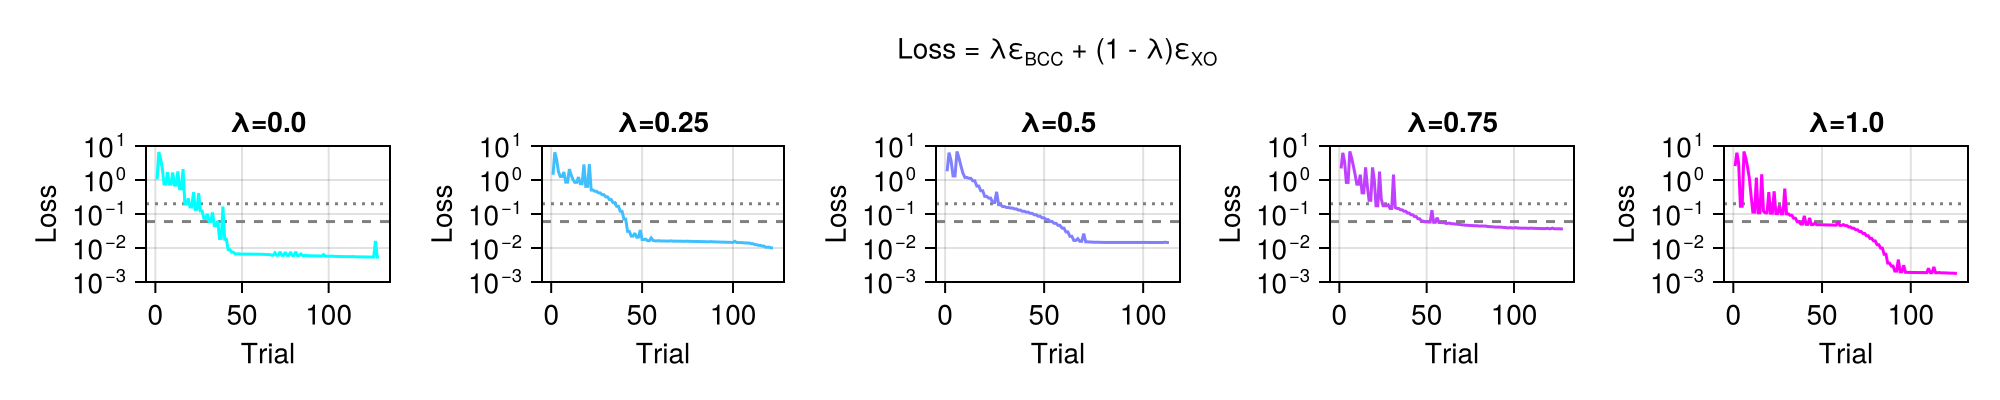

In [4]:
let
    fig = Figure(size=(1000,200))
    Label(fig[0,1:5], rich("Loss = λε", subscript("BCC"), " + (1 - λ)ε", subscript("XO")))
    for (i, λ) in enumerate(λ_range)
        loss = data[files[i]].loss
        xticks = filter(x -> (mod(x, 50) == 0), 0:length(loss)-1)
        ax = Makie.Axis(fig[1,i]; title="λ=$λ", xlabel="Trial", ylabel="Loss", xticks, yscale=log10)
        ylims!(ax, (1e-3,10))
        hlines!(ax, [0.2], color=:gray, linestyle=:dot)
        hlines!(ax, [0.06], color=:gray, linestyle=:dash)
        lines!(ax, loss, color=cmap[i])
    end
    fig
end

## Evaluation

In [5]:
train_paths = [
    (0.0,  "train0.0"),
    (0.25, "train0.25"),
    (0.5,  "train0.5"),
    (0.75, "train0.75"),
    (1.0,  "train1.0"),
]
eval_df = DataFrame()
for (λ, path) in train_paths
    for name in ["Li-BCC", "Li-XO"]
        res = JSON3.read(joinpath(path, "eval", "$name.json"))
        theta = res["theta"]
        Ecut = res["Ecut"]
        kgrid = res["kgrid"]
        energies = Vector(res["energies"])
        push!(eval_df, (; λ, path, theta, name, Ecut, kgrid, energies))
    end
end
eval_df

Row,λ,path,theta,name,Ecut,kgrid,energies
,Float64,String,Array…,String,Int64,Array…,Array…
1,0.0,train0.0,"[-1.97018, 0.35687, 0.59142, 0.966942, 1.32955, -0.00552261]",Li-BCC,20,"[8, 8, 8]","[-0.298538, -0.298087, -0.297632, -0.297173, -0.296712, -0.296248, -0.295783]"
2,0.0,train0.0,"[-1.97018, 0.35687, 0.59142, 0.966942, 1.32955, -0.00552261]",Li-XO,120,"[8, 8, 8]","[-8.15182, -8.15198, -8.15207, -8.1521, -8.15208, -8.152, -8.15188]"
3,0.25,train0.25,"[-0.2527, 0.013075, 0.597164, 1.02028, 1.95105, -0.00618314]",Li-BCC,20,"[8, 8, 8]","[-0.262014, -0.26209, -0.262136, -0.262154, -0.262147, -0.262116, -0.262064]"
4,0.25,train0.25,"[-0.2527, 0.013075, 0.597164, 1.02028, 1.95105, -0.00618314]",Li-XO,120,"[8, 8, 8]","[-8.14642, -8.14658, -8.14668, -8.14671, -8.14668, -8.14661, -8.14649]"
5,0.5,train0.5,"[-0.0849308, -0.0196733, 0.568593, 0.624446, 2.17789, 0.00108497]",Li-BCC,20,"[8, 8, 8]","[-0.263321, -0.263397, -0.263444, -0.263462, -0.263455, -0.263424, -0.263372]"
6,0.5,train0.5,"[-0.0849308, -0.0196733, 0.568593, 0.624446, 2.17789, 0.00108497]",Li-XO,120,"[8, 8, 8]","[-8.14644, -8.1466, -8.1467, -8.14673, -8.1467, -8.14663, -8.14651]"
7,0.75,train0.75,"[0.512197, -0.0872821, 0.528737, 0.965762, 2.34776, -0.0255744]",Li-BCC,20,"[8, 8, 8]","[-0.26325, -0.263327, -0.263374, -0.263392, -0.263385, -0.263354, -0.263301]"
8,0.75,train0.75,"[0.512197, -0.0872821, 0.528737, 0.965762, 2.34776, -0.0255744]",Li-XO,120,"[8, 8, 8]","[-8.14728, -8.14745, -8.14755, -8.14759, -8.14756, -8.14748, -8.14735]"
9,1.0,train1.0,"[-0.178248, 0.0433648, 0.401202, 1.081, 2.67973, 0.0516924]",Li-BCC,20,"[8, 8, 8]","[-0.279756, -0.279834, -0.279881, -0.2799, -0.279892, -0.27986, -0.279807]"


In [6]:
wien2k_bcc = JSON3.read("all_electron_data/wien2k_Li-BCC.json")

JSON3.Object{Vector{UInt8}, Vector{UInt64}} with 2 entries:
  :volumes_Ang3 => [19.05, 19.4553, 19.8606, 20.2659, 20.6712, 21.0766, 21.4819]
  :energies_eV  => [-204.685, -204.687, -204.688, -204.688, -204.688, -204.687,…

In [7]:
wien2k_xo = JSON3.read("all_electron_data/wien2k_Li-XO.json")

JSON3.Object{Vector{UInt8}, Vector{UInt64}} with 2 entries:
  :volumes_Ang3 => [15.8184, 16.1549, 16.4915, 16.8281, 17.1646, 17.5012, 17.83…
  :energies_eV  => [-2252.44, -2252.45, -2252.45, -2252.45, -2252.45, -2252.45,…

In [8]:
e_ref_wien2k = Dict(
    "Li-BCC"=>ustrip.(uconvert.(u"meV", wien2k_bcc[:energies_eV] * u"eV")) / 1,
    "Li-XO" =>ustrip.(uconvert.(u"meV", wien2k_xo[:energies_eV] * u"eV")) / 2,
)

Dict{String, Vector{Float64}} with 2 entries:
  "Li-XO"  => [-1.12622e6, -1.12622e6, -1.12622e6, -1.12623e6, -1.12623e6, -1.1…
  "Li-BCC" => [-204685.0, -2.04687e5, -2.04688e5, -2.04688e5, -2.04688e5, -2.04…

In [9]:
e_ref_kgrid8 = Dict(
    "Li-BCC"=>JSON3.read("convergence_study_Li_q3/Li-BCC_Ecut120_kgrid8.json")[:energies],
    "Li-XO" =>JSON3.read("convergence_study_Li_q3/Li-XO_Ecut120_kgrid8.json")[:energies],
)

Dict{String, JSON3.Array{Float64, Vector{UInt8}, SubArray{UInt64, 1, Vector{UInt64}, Tuple{UnitRange{Int64}}, true}}} with 2 entries:
  "Li-XO"  => [-11.753, -11.7531, -11.7532, -11.7532, -11.7532, -11.7531, -11.7…
  "Li-BCC" => [-7.47259, -7.47267, -7.47272, -7.47274, -7.47273, -7.4727, -7.47…

In [10]:
# Load initial predictions
e_θinit = Dict(
    "Li-BCC"=>data[files[3]].cases[1]["Li-BCC"]["energies"],
    "Li-XO" =>data[files[3]].cases[1]["Li-XO"]["energies"],
)

Dict{String, JSON3.Array{Float64, Vector{UInt8}, SubArray{UInt64, 1, Vector{UInt64}, Tuple{UnitRange{Int64}}, true}}} with 2 entries:
  "Li-XO"  => [7.60448e-5, -5.5103e-6, -2.94757e-5, 0.0, 7.66757e-5, 0.00019519…
  "Li-BCC" => [-0.000345811, -0.000250893, -0.000135002, 0.0, 0.000152442, 0.00…

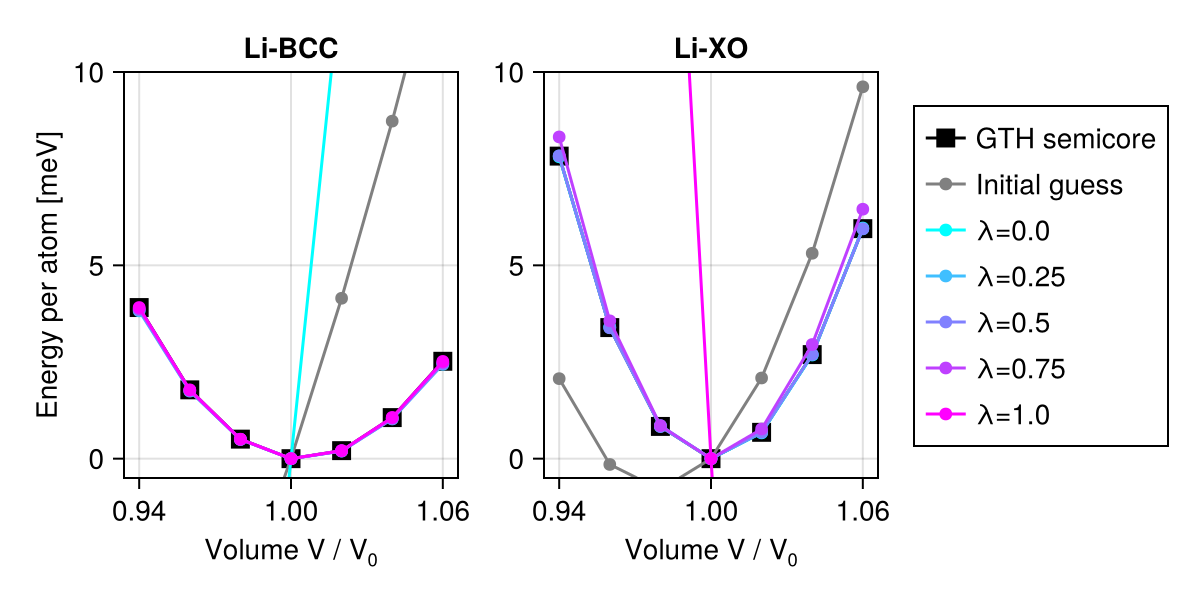

In [11]:
let fig = Figure(size=(600,300))
    v = [0.94, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06]

    xticks = [0.94, 1.0, 1.06]

    axs = [
        Makie.Axis(fig[1,1]; title="Li-BCC", ylabel="Energy per atom [meV]", xlabel=rich("Volume V / V", subscript("0")), xticks),
        Makie.Axis(fig[1,2]; title="Li-XO", 
            # ylabel="Energy per atom [meV]", 
            xlabel=rich("Volume V / V", subscript("0")), xticks),
    ]

    for (j, name) in enumerate(["Li-BCC", "Li-XO"])
        # e = e_ref_wien2k[name]
        # scatterlines!(axs[i], v, e .- e[4], label="AE", color=:gray, markersize=15, marker=:rect)

        e = e_ref_kgrid8[name]
        e = e .- e[4]
        e = ustrip.(uconvert.(u"meV", e * u"hartree"))
        scatterlines!(axs[j], v, e, label="GTH semicore", color=:black, markersize=15, marker=:rect)

        e = e_θinit[name]
        e = e .- e[4]
        e = ustrip.(uconvert.(u"meV", e * u"hartree"))
        scatterlines!(axs[j], v, e, label="Initial guess", color=:gray)

        
        for (i, λ) in enumerate(λ_range)
            e = only(eval_df[(eval_df.λ .== λ) .&& (eval_df.name .== name), :energies])
            e = e .- e[4]
            e = ustrip.(uconvert.(u"meV", e * u"hartree"))
            scatterlines!(axs[j], v, e, label="λ=$λ", color=cmap[i])
        end
    end
    ylims!(axs[1], (-0.5, 10))
    ylims!(axs[2], (-0.5, 10))
    # axislegend(axs[2], position=:ct)
    Legend(fig[1,3], axs[2])

    save("gth_liq1_energies.pdf", fig)

    fig
end

In [12]:
function ε(energies_a, energies_b)
    @assert length(energies_a) == length(energies_b) == 7
    Ea = energies_a .- energies_a[4]
    Eb = energies_b .- energies_b[4]
    sqrt(
        sum(abs2, Ea - Eb) / (
            sqrt(sum(abs2, Ea .- mean(Ea)) * sum(abs2, Eb .- mean(Eb)))
        )
    )
end

ε (generic function with 1 method)

In [13]:
for λ in λ_range
    @show λ
    for name in ["Li-BCC", "Li-XO"]
        e = only(eval_df[(eval_df.λ .== λ) .&& (eval_df.name .== name), :energies])
        e = ustrip.(uconvert.(u"meV", e * u"hartree"))
        eref = ustrip.(uconvert.(u"meV", e_ref_kgrid8[name] * u"hartree"))
        print("$name: $(ε(e, eref)), ")
    end
    println()
end

λ = 0.0
Li-BCC: 4.455041835938214, Li-XO: 0.005439259372849153, 
λ = 0.25
Li-BCC: 0.03715512665988217, Li-XO: 0.0010756908683745498, 
λ = 0.5
Li-BCC: 0.02780829315840487, Li-XO: 0.0011968605059984733, 
λ = 0.75
Li-BCC: 0.013475794704470218, Li-XO: 0.10508946549006859, 
λ = 1.0
Li-BCC: 0.0017905294826715513, Li-XO: 3.997468755322911, 


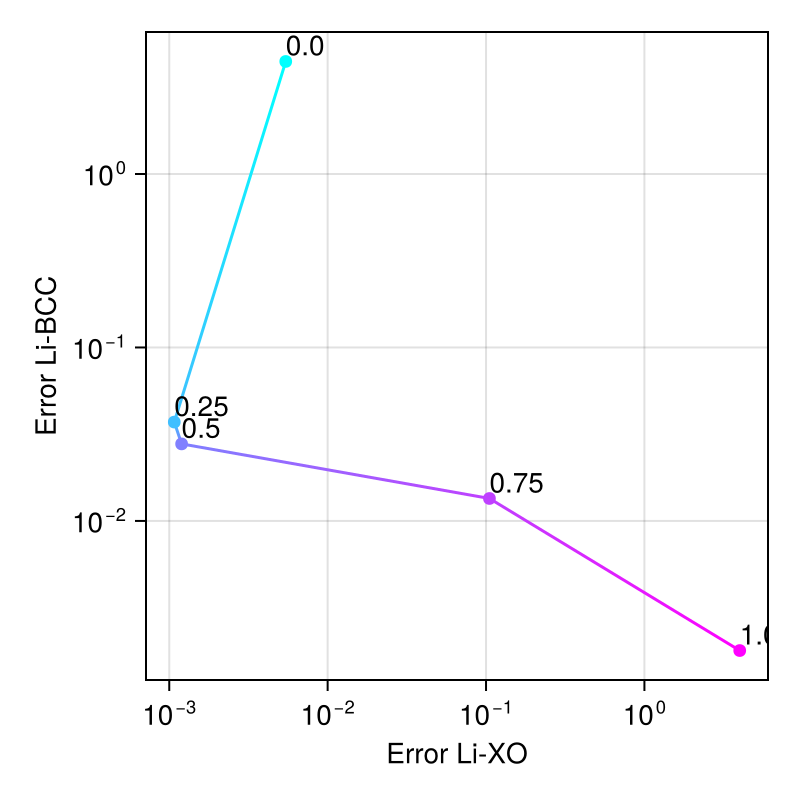

In [14]:
let 
    xo_err = map(λ_range) do λ
        ea = only(eval_df[(eval_df.λ .== λ) .&& (eval_df.name .== "Li-XO"), :energies])
        ea = ustrip.(uconvert.(u"meV", ea * u"hartree"))

        eb = e_ref_kgrid8["Li-XO"]
        eb = ustrip.(uconvert.(u"meV", eb * u"hartree"))
        ε(ea, eb)
    end

    bcc_err = map(λ_range) do λ 
        ea = only(eval_df[(eval_df.λ .== λ) .&& (eval_df.name .== "Li-BCC"), :energies])
        ea = ustrip.(uconvert.(u"meV", ea * u"hartree"))

        eb = e_ref_kgrid8["Li-BCC"]
        eb = ustrip.(uconvert.(u"meV", eb * u"hartree"))
        ε(ea, eb)
    end

    fig = Figure(size=(400,400))
    ax = Makie.Axis(
        fig[1,1],
        xlabel="Error Li-XO", ylabel="Error Li-BCC",
        xscale=log10, yscale=log10,
    )
    scatterlines!(ax, xo_err, bcc_err, color=λ_range, colormap=ColorSchemes.cool)
    text!(ax, xo_err, bcc_err, text=string.(λ_range))
    fig
end

## What happened to the potential itself?

In [15]:
# Load GTH PBE pseudopotential table
pseudopotentials = PseudoFamily("cp2k.nc.sr.pbe.v0_1.largecore.gth")

# Load initial parameters for Li-q1 (only LDA available for q1)
Li_q1_init = ElementPsp(:Li, PseudoFamily("cp2k.nc.sr.lda.v0_1.largecore.gth"))

# Expose optimisable parameters
make_li_q1(θ) = unflatten(ComponentVector(; θ..., rloc=Li_q1_init.psp.rloc))
params = flatten(Li_q1_init)
tunable_param_keys = [:cloc1, :cloc2, :rp1, :rp2, :h1, :h2]
θ_init = params[tunable_param_keys]

ComponentVector{Float64}(cloc1 = -1.89261247, cloc2 = 0.28605968, rp1 = 0.66637518, rp2 = 1.07930561, h1 = 1.85881111, h2 = -0.00589504)

In [16]:
function load_params(θraw)
    θ = deepcopy(θ_init)
    θ .= θraw
    θ
end

θ = Dict(
    λ => load_params(only(unique(eval_df[eval_df.λ .== λ, :].theta))) for λ in λ_range
)

Dict{Float64, ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(cloc1 = 1, cloc2 = 2, rp1 = 3, rp2 = 4, h1 = 5, h2 = 6)}}}} with 5 entries:
  0.0  => (cloc1 = -1.97018, cloc2 = 0.35687, rp1 = 0.59142, rp2 = 0.966942, h1…
  0.5  => (cloc1 = -0.0849308, cloc2 = -0.0196733, rp1 = 0.568593, rp2 = 0.6244…
  0.25 => (cloc1 = -0.2527, cloc2 = 0.013075, rp1 = 0.597164, rp2 = 1.02028, h1…
  0.75 => (cloc1 = 0.512197, cloc2 = -0.0872821, rp1 = 0.528737, rp2 = 0.965762…
  1.0  => (cloc1 = -0.178248, cloc2 = 0.0433648, rp1 = 0.401202, rp2 = 1.081, h…

In [17]:
let df = DataFrame()
    push!(df, (; key="Init", θ_init...))
    for λ in λ_range
        params = load_params(only(unique(eval_df[eval_df.λ .== λ, :].theta)))
        push!(df, (; key="λ=$λ", params...))
    end
    df
end

Row,key,cloc1,cloc2,rp1,rp2,h1,h2
,String,Float64,Float64,Float64,Float64,Float64,Float64
1,Init,-1.89261,0.28606,0.666375,1.07931,1.85881,-0.00589504
2,λ=0.0,-1.97018,0.35687,0.59142,0.966942,1.32955,-0.00552261
3,λ=0.25,-0.2527,0.013075,0.597164,1.02028,1.95105,-0.00618314
4,λ=0.5,-0.0849308,-0.0196733,0.568593,0.624446,2.17789,0.00108497
5,λ=0.75,0.512197,-0.0872821,0.528737,0.965762,2.34776,-0.0255744
6,λ=1.0,-0.178248,0.0433648,0.401202,1.081,2.67973,0.0516924


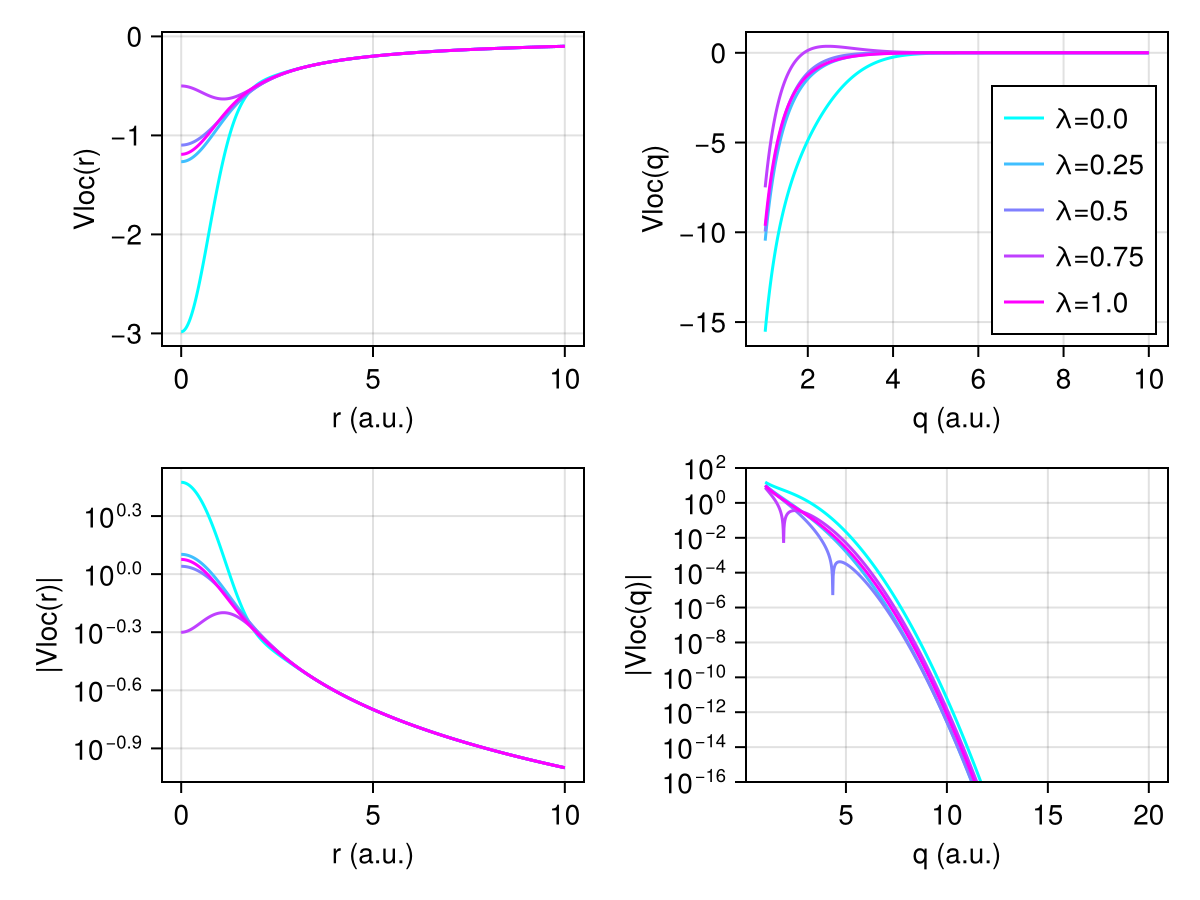

In [18]:
fig = Figure()

ax = Makie.Axis(fig[1,1], xlabel="r (a.u.)", ylabel="Vloc(r)")
r = range(0, 10.0, length=1000)
for (i, λ) in enumerate(λ_range)
    y = DFTK.local_potential_real.(Ref(make_li_q1(θ[λ])), r)
    lines!(ax, r, y; label="λ=$λ", color=cmap[i])
end

ax = Makie.Axis(fig[1,2], xlabel="q (a.u.)", ylabel="Vloc(q)")
q = range(1, 10, length=1000)
for (i, λ) in enumerate(λ_range)
    y = DFTK.local_potential_fourier.(Ref(make_li_q1(θ[λ])), q)
    lines!(ax, q, y; label="λ=$λ", color=cmap[i])
end
axislegend(ax, position=:rb)

ax = Makie.Axis(fig[2,1], xlabel="r (a.u.)", ylabel="|Vloc(r)|", yscale=log10)
r = range(0, 10.0, length=1000)
for (i, λ) in enumerate(λ_range)
    y = DFTK.local_potential_real.(Ref(make_li_q1(θ[λ])), r)
    lines!(ax, r, abs.(y); label="λ=$λ", color=cmap[i])
end

ax = Makie.Axis(fig[2,2], xlabel="q (a.u.)", ylabel="|Vloc(q)|", yscale=log10)
q = range(1, 20, length=1000)
for (i, λ) in enumerate(λ_range)
    y = DFTK.local_potential_fourier.(Ref(make_li_q1(θ[λ])), q)
    lines!(ax, q, abs.(y); label="λ=$λ", color=cmap[i])
end
ylims!(ax, (1e-16, 1e2))
# axislegend(ax, position=:rb)

fig

## Composite Figure

In [19]:
Li_q3 = ElementPsp(:Li, pseudopotentials)

ElementPsp(:Li, PseudoFamily("cp2k.nc.sr.pbe.v0_1.largecore.gth"))

In [20]:
λ_range3 = [0.25, 0.5, 0.75]
cmap3 = resample(ColorSchemes.cool, 3)

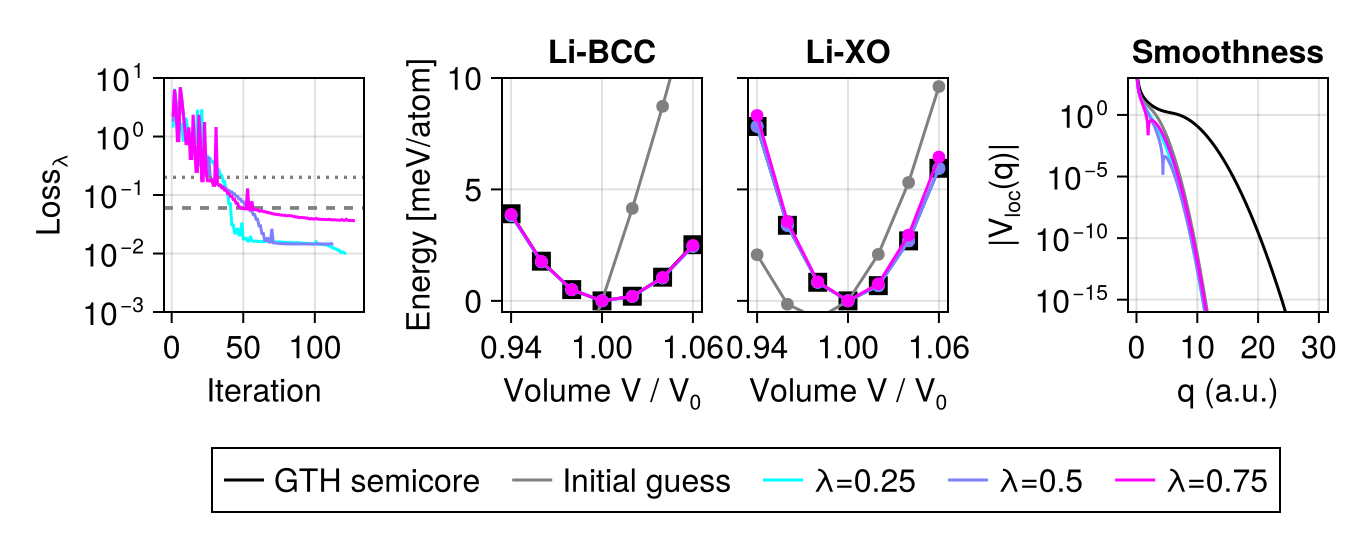

In [44]:
let # fig = Figure(size=(900,240))
    fig = Figure(size=(2 * default_width, 0.8 * default_width), fontsize=12pt)

    ax = Makie.Axis(fig[1,1]; xlabel="Iteration", ylabel=rich("Loss", subscript("λ")), yscale=log10)
    for (i, λ) in enumerate([0.25, 0.5, 0.75])
        loss = data["train$(λ)/trajectory.json"].loss
        ylims!(ax, (1e-3,10))
        hlines!(ax, [0.2], color=:gray, linestyle=:dot)
        hlines!(ax, [0.06], color=:gray, linestyle=:dash)
        lines!(ax, loss, color=cmap3[i], label="λ=$λ")
    end


    v = [0.94, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06]
    xticks = [0.94, 1.0, 1.06]
    axs = [
        Makie.Axis(fig[1,2]; title="Li-BCC", 
            ylabel="Energy [meV/atom]", 
            xlabel=rich("Volume V / V", subscript("0")), 
            xticks,
            # xticklabelsvisible=false,
        ),
        Makie.Axis(fig[1,3]; title="Li-XO", 
            # ylabel="Energy per atom [meV]", 
            xlabel=rich("Volume V / V", subscript("0")),
            xticks,
        ),
    ]

    # Label(fig[1:2,2], "Energy per atom [meV]", rotation=pi/2)

    for (j, name) in enumerate(["Li-BCC", "Li-XO"])
        # e = e_ref_wien2k[name]
        # scatterlines!(axs[i], v, e .- e[4], label="AE", color=:gray, markersize=15, marker=:rect)

        e = e_ref_kgrid8[name]
        e = e .- e[4]
        e = ustrip.(uconvert.(u"meV", e * u"hartree"))
        scatterlines!(axs[j], v, e, label="GTH semicore", color=:black, markersize=15, marker=:rect)

        e = e_θinit[name]
        e = e .- e[4]
        e = ustrip.(uconvert.(u"meV", e * u"hartree"))
        scatterlines!(axs[j], v, e, label="Initial guess", color=:gray)
        
        for (i, λ) in enumerate(λ_range3)
            e = only(eval_df[(eval_df.λ .== λ) .&& (eval_df.name .== name), :energies])
            e = e .- e[4]
            e = ustrip.(uconvert.(u"meV", e * u"hartree"))
            scatterlines!(axs[j], v, e, label="λ=$λ", color=cmap3[i])
        end
    end
    ylims!(axs[1], (-0.5, 10))
    ylims!(axs[2], (-0.5, 10))
    axs[2].yticklabelsvisible = false
    # axislegend(axs[2], position=:ct)
    # Legend(fig[1,2], axs[2])

    ax = Makie.Axis(fig[1,4], xlabel="q (a.u.)", ylabel=rich("|V", subscript("loc") ,"(q)|"), yscale=log10, title="Smoothness")
    lines!(ax, q, abs.(DFTK.local_potential_fourier.(Ref(Li_q3), q));
        label="GTH semicore", color=:black)
    lines!(ax, q, abs.(DFTK.local_potential_fourier.(Ref(Li_q1_init), q));
        label="Initial guess", color=:gray)
    for (i, λ) in enumerate(λ_range3)
        y = DFTK.local_potential_fourier.(Ref(make_li_q1(θ[λ])), q)
        lines!(ax, q, abs.(y); label="λ=$λ", color=cmap3[i])
    end
    ylims!(ax, (1e-16, 1e3))
    # axislegend(ax, position=:rb)

    # Legend(fig[1,5], ax)
    Legend(fig[2,:], ax, orientation=:horizontal)

    save("gth_liq1_energies_and_localpotential.pdf", fig)

    fig
end